<a href="https://colab.research.google.com/github/pragya79/VGG16-Classifier/blob/main/IndianCuisineClassifier%20(ResNet50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [216]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
!nvidia-smi

Mon Jul 15 05:03:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              30W /  70W |   8317MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [365]:
import os
path='/content/drive/MyDrive/reduced_dataset'

In [314]:
#removing corrupted images
from PIL import Image

def check_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Bad file: {file_path}")
                os.remove(file_path)  # Remove the corrupted file

# Check and clean your dataset directory
dataset_path = '/content/drive/MyDrive/images'
check_images(dataset_path)


In [315]:
import tensorflow as tf
from tensorflow import keras

In [316]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**DATA AUGMENTATION**

In [366]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3
)

In [367]:
train_gen=train_datagen.flow_from_directory(
    path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True
)

Found 843 images belonging to 35 classes.


In [368]:
validation_gen=train_datagen.flow_from_directory(
    path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    shuffle=True
)

Found 349 images belonging to 35 classes.


In [369]:
print(train_gen.class_indices)
print(validation_gen.class_indices)


{'Aloo Puri': 0, 'Amritsari Kulcha': 1, 'Apong': 2, 'Babru': 3, 'Bhakarwadi': 4, 'Bhindi Masala': 5, 'Biryani': 6, 'Chhole Bhature': 7, 'Dabeli': 8, 'Dal Bati': 9, 'Dal Dhokli': 10, 'Dhokla': 11, 'Fafda-Jalebi': 12, 'Gatte ki Sabzi': 13, 'Ghevar': 14, 'Idli Dosa': 15, 'Khakra': 16, 'Khandvi': 17, 'Modak': 18, 'Naan': 19, 'Paneer Butter Masala': 20, 'Paneer Tikka': 21, 'Paratha': 22, 'Pav Bhaji': 23, 'Peda': 24, 'Rajma': 25, 'Rasgulla': 26, 'Rugra': 27, 'Sattu Paratha': 28, 'Sondesh': 29, 'Thekua': 30, 'Thukpa': 31, 'Tilkut': 32, 'Uttapam': 33, 'Vada Pav': 34}
{'Aloo Puri': 0, 'Amritsari Kulcha': 1, 'Apong': 2, 'Babru': 3, 'Bhakarwadi': 4, 'Bhindi Masala': 5, 'Biryani': 6, 'Chhole Bhature': 7, 'Dabeli': 8, 'Dal Bati': 9, 'Dal Dhokli': 10, 'Dhokla': 11, 'Fafda-Jalebi': 12, 'Gatte ki Sabzi': 13, 'Ghevar': 14, 'Idli Dosa': 15, 'Khakra': 16, 'Khandvi': 17, 'Modak': 18, 'Naan': 19, 'Paneer Butter Masala': 20, 'Paneer Tikka': 21, 'Paratha': 22, 'Pav Bhaji': 23, 'Peda': 24, 'Rajma': 25, 'Rasgu

In [325]:
# Verify the output shape of data generators
batch_x, batch_y = next(train_gen)
print(f"Shape of batch_x: {batch_x.shape}")
print(f"Shape of batch_y: {batch_y.shape}")

Shape of batch_x: (32, 224, 224, 3)
Shape of batch_y: (32, 64)


In [370]:
from tensorflow.keras import layers,models
from tensorflow.keras.applications import ResNet50

In [371]:
reference_model=ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

**Tranfer Learning**

In [379]:
# freezing the layers
for layer in reference_model.layers:
    layer.trainable=False

In [380]:
model = models.Sequential([
    reference_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(units=256, activation='relu'),#kernel_regularizer=tf.keras.regularizers.l2(0.01)=> L2 Regularization to overcome the problem of Overfitting
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=35, activation='softmax')
])

In [381]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [382]:
model.compile(
    #as my model is overfitting i.e. gap b/w training accuracy and test accuracy is large hence using low learning rate
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy']

)

In [383]:
print(layer,layer.trainable)

<keras.src.layers.core.activation.Activation object at 0x78df348e3430> False


**Fine Tuning**

In [384]:
# Unfreezing some layers
for layer in reference_model.layers[-4:]:  #last 4 layers are unfreezed now
    layer.trainable = True

model.compile(
        tf.keras.optimizers.Adam(learning_rate=0.01),#taking lower learning_rate for fine tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

In [385]:
print(layer,layer.trainable)

<keras.src.layers.core.activation.Activation object at 0x78df348e3430> True


In [386]:
trained_model=model.fit(
    train_gen,
    epochs=20,
    validation_data=validation_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(validation_gen),
)

Epoch 1/20
27/27 [==============================] - 43s 1s/step - loss: 4.8334 - accuracy: 0.0795 - val_loss: 312.6504 - val_accuracy: 0.0172
Epoch 2/20
27/27 [==============================] - 28s 1s/step - loss: 3.9099 - accuracy: 0.1103 - val_loss: 91.3636 - val_accuracy: 0.0143
Epoch 3/20
27/27 [==============================] - 26s 958ms/step - loss: 3.6409 - accuracy: 0.1234 - val_loss: 23.0968 - val_accuracy: 0.0716
Epoch 4/20
27/27 [==============================] - 25s 943ms/step - loss: 3.4438 - accuracy: 0.1281 - val_loss: 6.9127 - val_accuracy: 0.1289
Epoch 5/20
27/27 [==============================] - 25s 905ms/step - loss: 3.2597 - accuracy: 0.1673 - val_loss: 5.0779 - val_accuracy: 0.1003
Epoch 6/20
27/27 [==============================] - 26s 983ms/step - loss: 3.1809 - accuracy: 0.1601 - val_loss: 4.1168 - val_accuracy: 0.0946
Epoch 7/20
27/27 [==============================] - 26s 950ms/step - loss: 3.1363 - accuracy: 0.1483 - val_loss: 3.8400 - val_accuracy: 0.0888
E

**Saving the Model as .h5 file**

In [280]:
saved_model=model.save('/content/drive/MyDrive/saved_model/fineTunedClassifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [282]:
from keras.models import load_model
model = load_model(saved_model)

In [387]:
# model.fit(
#     train_gen,
#     epochs=20,
#     validation_data=validation_gen,
#     steps_per_epoch=len(train_gen),
#     validation_steps=len(validation_gen),
#     callbacks=[early_stopping]
# )

In [388]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_35 (Flatten)        (None, 100352)            0         
                                                                 
 batch_normalization_79 (Ba  (None, 100352)            401408    
 tchNormalization)                                               
                                                                 
 dense_82 (Dense)            (None, 256)               25690368  
                                                                 
 batch_normalization_80 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_35 (Dropout)        (None, 256)             

In [389]:
y_predict=model.predict(validation_gen)

11/11 [==============================] - 8s 695ms/step


In [390]:
model.evaluate(validation_gen)

11/11 [==============================] - 7s 658ms/step - loss: 3.9248 - accuracy: 0.0774


[3.9247846603393555, 0.07736389338970184]

In [391]:
from sklearn.metrics import classification_report
y_true=validation_gen.classes# 35 classes
print(classification_report(y_true,y_predict.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        27
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00        10
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [392]:
import matplotlib.pyplot as plt

In [393]:

training_loss=trained_model.history['loss']
test_loss=trained_model.history['val_loss']#loss on validation dataset
training_acc=trained_model.history['accuracy']#accuracy on training dataset
test_acc=trained_model.history['val_accuracy']#accuracy on validation dataset
epochs=range(len(training_loss))

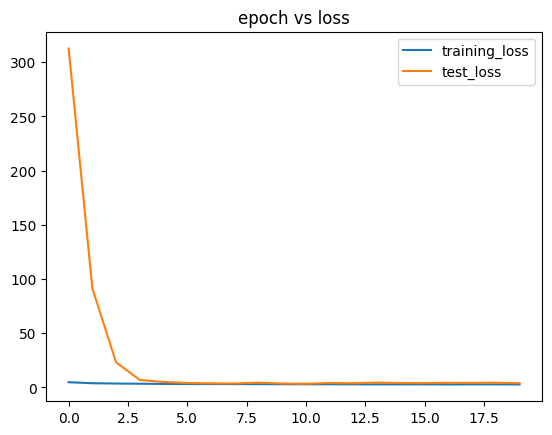

In [394]:
#ploting epoch vs training_loss & epoch vs test_loss graph

plt.title('epoch vs loss')
plt.plot(epochs,training_loss,label='training_loss')
plt.plot(epochs,test_loss,label='test_loss')
plt.legend()
plt.show()


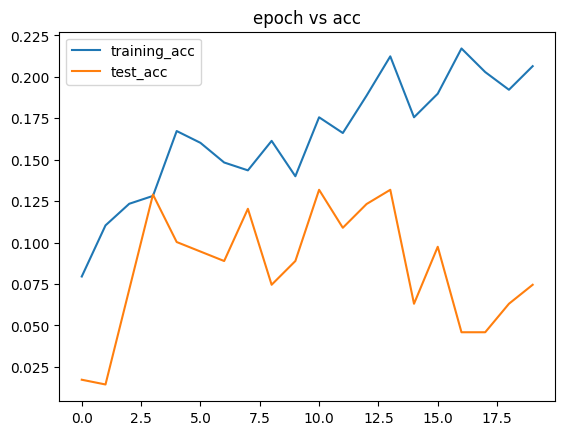

In [395]:
#ploting epoch vs tarining_acc & epoch vs test_acc graph
plt.title('epoch vs acc')
plt.plot(epochs,training_acc,label='training_acc')
plt.plot(epochs,test_acc,label='test_acc')
plt.legend()
plt.show()

Using the Saved model to predict new images as one of the classes

In [397]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
#function to predict images
def predict_image(image_path,saved_model):
  img=image.load_img(image_path,target_size=(224,224))
  img=image.img_to_array(img)
  img=img/255.0

  img=np.expand_dims(img,axis=0)

  prediction=saved_model.predict(img)
  classes = ['Aloo Puri', 'Amritsari Kulcha', 'Apong', 'Babru', 'Bhakarwadi',
             'Bhindi Masala', 'Biryani', 'Chhole Bhature', 'Dabeli', 'Dal Bati',
             'Dal Dhokli', 'Dhokla', 'Fafda-Jalebi', 'Gatte ki Sabzi', 'Ghevar',
             'Idli Dosa', 'Khakra', 'Khandvi', 'Modak', 'Naan', 'Paneer Butter Masala',
             'Paneer Tikka', 'Paratha', 'Pav Bhaji', 'Peda', 'Rajma', 'Rasgulla',
             'Rugra','Sattu Paratha', 'Sondesh', 'Thekua', 'Thukpa', 'Tilkut', 'Uttapam',
             'Vada Pav']

  predicted_class=classes[np.argmax(prediction)]

  return predicted_class



In [399]:
saved_model=load_model('/content/drive/MyDrive/saved_model/fineTunedClassifier.h5')
image_path='/content/drive/MyDrive/new.jfif'
predicted_class=predict_image(image_path,saved_model)
print(predicted_class)

1/1 [==============================] - 2s 2s/step
Pav Bhaji
